In [2]:
import pandas as pd
import numpy.random as rd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import rpy2
from rpy2.robjects.packages import importr
import rpy2.robjects as robjects
from rpy2.rinterface import R_VERSION_BUILD
from rpy2.robjects import pandas2ri
pandas2ri.activate()

In [7]:
rd.seed(71)

T = 500
v_sd = 20
i_sd = 10
a10 = 10
e_sd1 = 0.5
a20 = 20
e_sd2 = 0.8

e1 = np.random.normal(0, e_sd1, size=T)
a1 = e1.cumsum() + a10
e2 = np.random.normal(0, e_sd2, size=T)
a2 = e2.cumsum() + a20

intercept = np.cumsum(np.random.normal(0, i_sd, size=T))

x1 = rd.normal(10, 10, size=T)
x2 = rd.normal(10, 10, size=T)

v = np.random.normal(0, v_sd, size=T)
y = intercept + a1*x1 + a2*x2 + v
y_noerror = intercept + a1*x1 + a2*x2

Text(0.5, 1.0, 'a1')

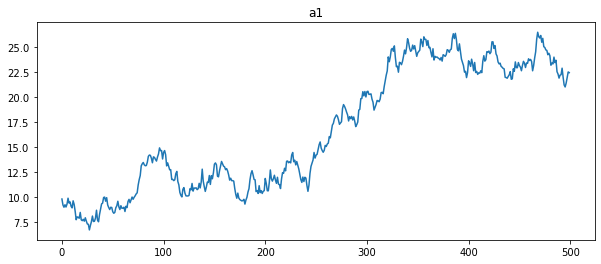

In [8]:
plt.figure(figsize=(10,4))
plt.plot(a1)
plt.title("a1")

Text(0.5, 1.0, 'a2')

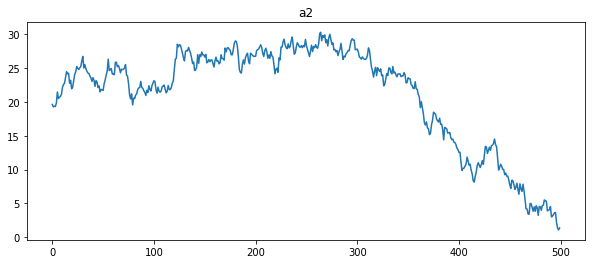

In [9]:
plt.figure(figsize=(10,4))
plt.plot(a2)
plt.title("a2")

Text(0.5, 1.0, 'intercept')

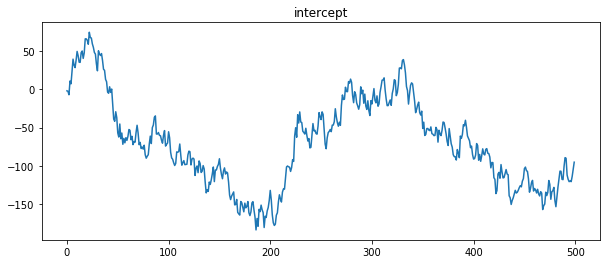

In [10]:
plt.figure(figsize=(10,4))
plt.plot(intercept)
plt.title("intercept")

Text(0.5, 1.0, 'x1')

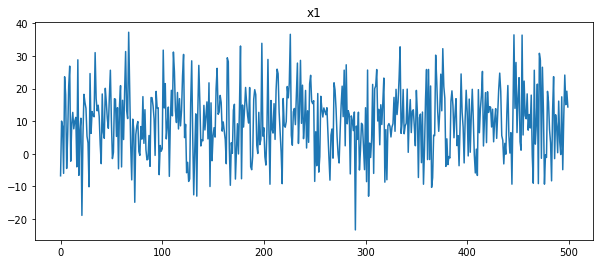

In [11]:
plt.figure(figsize=(10,4))
plt.plot(x1)
plt.title("x1")

Text(0.5, 1.0, 'x2')

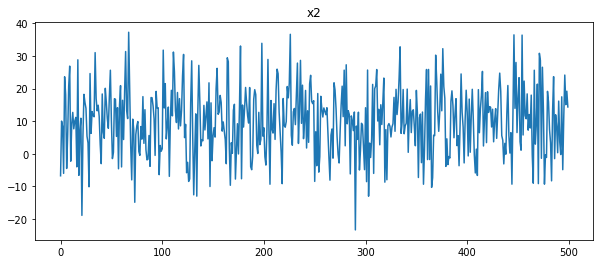

In [12]:
plt.figure(figsize=(10,4))
plt.plot(x1)
plt.title("x2")

Text(0.5, 1.0, 'y')

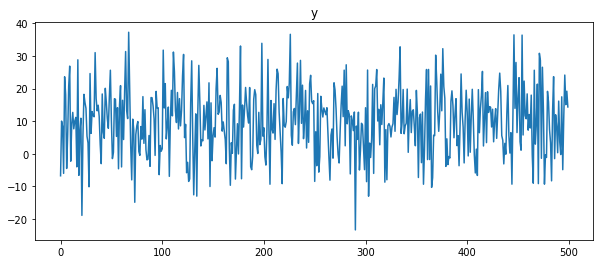

In [13]:
plt.figure(figsize=(10,4))
plt.plot(x1)
plt.title("y")

Text(0.5, 1.0, 'v')

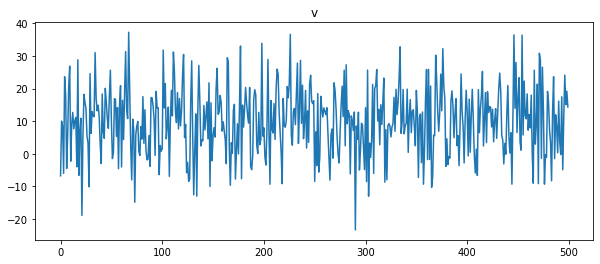

In [14]:
plt.figure(figsize=(10,4))
plt.plot(x1)
plt.title("v")

In [15]:
df = pd.DataFrame({"x1":x1, "x2":x2, "y":y, "a1":a1,  "a2":a2, "intercept":intercept})
df.head()

,x1,x2,y,a1,a2,intercept
0,-6.768232,-4.238996,-149.547649,9.784698,19.610076,-2.215152
1,10.001302,16.760184,438.058268,9.187734,19.249373,-2.804606
2,8.388453,4.014684,150.659873,8.965585,19.348741,-7.342012
3,-6.030999,1.090963,-16.883775,9.210291,19.297976,10.552154
4,23.608283,-0.249615,226.788912,8.984512,19.822178,6.933788


In [17]:
def get_method(result, method_name):
    for i in result.items():
        if i[0] == method_name:
            return i[1]
    assert False

In [18]:
def show_result(result):
    for i in result.items():
        print(i[0], i[1], )

In [19]:
dlm = importr("dlm")

In [20]:
buildDlmReg = lambda theta: dlm.dlmModReg(
    X = df[["x1", "x2"]], 
    dV = np.exp(theta[0]), 
    dW = [np.exp(theta[1]), np.exp(theta[2]), np.exp(theta[3])]
  )

In [21]:
parm = dlm.dlmMLE(y, parm = [2, 1, 1, 1], build = buildDlmReg, method = "L-BFGS-B") #Nelder-Mead")
par = np.array(get_method(parm, "par"))
print("par:", par)
fitDlmReg = dlm.dlmMLE(y, parm=par, build=buildDlmReg, method="SANN")#SANN", "L-BFGS-B"

par: [ 5.99988463  4.57242133 -1.65722425 -0.92329885]


In [22]:
show_result(fitDlmReg)

par [1]  5.9998846  4.5724213 -1.6572242 -0.9232988

value [1] 2017.984

counts function gradient 
   10000       NA 

convergence [1] 0

message NULL


In [23]:
convergence = get_method(fitDlmReg, "convergence")
print("convergence:", convergence[0])

convergence: 0


In [24]:
par = np.asanyarray(get_method(fitDlmReg, "par"))
modDlmReg = buildDlmReg(par)

In [28]:
#show_result(modDlmReg)

In [29]:
estimated_sd = np.sqrt(np.exp(np.array(get_method(fitDlmReg, "par"))))

pd.DataFrame({"estimated_sd":estimated_sd, "sd":[v_sd, i_sd, e_sd1, e_sd2]})

,estimated_sd,sd
0,20.084378,20.0
1,9.837589,10.0
2,0.436655,0.5
3,0.630243,0.8


In [30]:

# カルマンフィルタ
filterDlmReg = dlm.dlmFilter(y, modDlmReg)

# スムージング
smoothDlmReg = dlm.dlmSmooth(filterDlmReg)

In [31]:
filtered_a = np.array(get_method(filterDlmReg, "a"))
smoothed_a = np.array(get_method(smoothDlmReg, "s"))

Text(0.5, 1.0, 'plot of intercept')

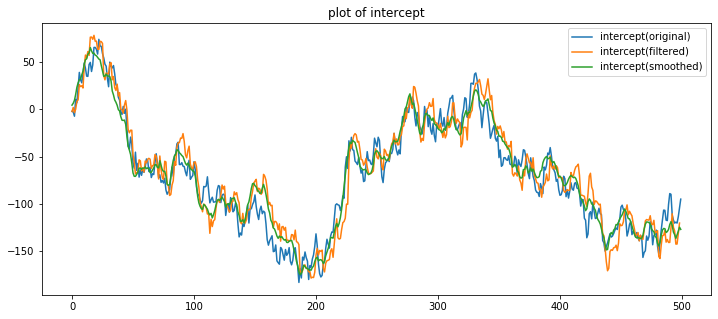

In [32]:
plt.figure(figsize=(12,5))
plt.plot(df.intercept, label="intercept(original)")
plt.plot(filtered_a[1:,0], label="intercept(filtered)")
plt.plot(smoothed_a[1:,0], label="intercept(smoothed)")
plt.legend(loc="best")
plt.title("plot of intercept")

Text(0.5, 1.0, 'plot of regression coeff a1')

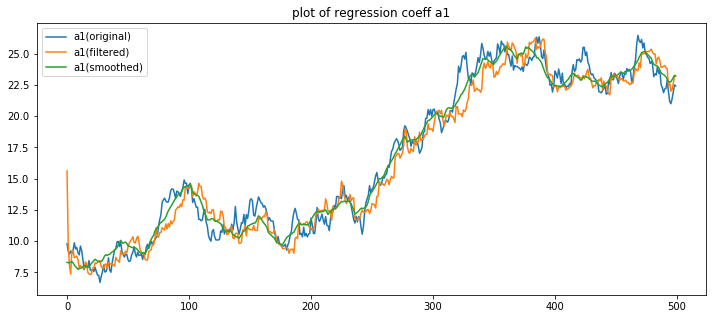

In [33]:
plt.figure(figsize=(12,5))
plt.plot(df.a1, label="a1(original)")
plt.plot(filtered_a[1:,1], label="a1(filtered)")
plt.plot(smoothed_a[1:,1], label="a1(smoothed)")
plt.legend(loc="best")
plt.title("plot of regression coeff a1")

Text(0.5, 1.0, 'plot of regression coeff a2')

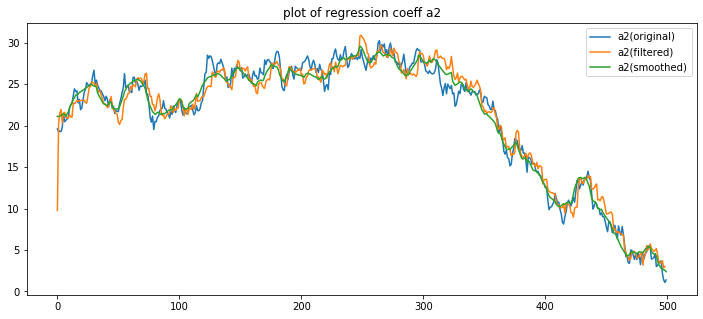

In [34]:
plt.figure(figsize=(12,5))
plt.plot(df.a2, label="a2(original)")
plt.plot(filtered_a[1:,2], label="a2(filtered)")
plt.plot(smoothed_a[1:,2], label="a2(smoothed)")
plt.legend(loc="best")
plt.title("plot of regression coeff a2")

In [35]:
estimatedLevel = smoothed_a[1:,0] + df.x1*smoothed_a[1:,1] + df.x2*smoothed_a[1:,2]

Text(0.5, 1.0, 'plot of target value.')

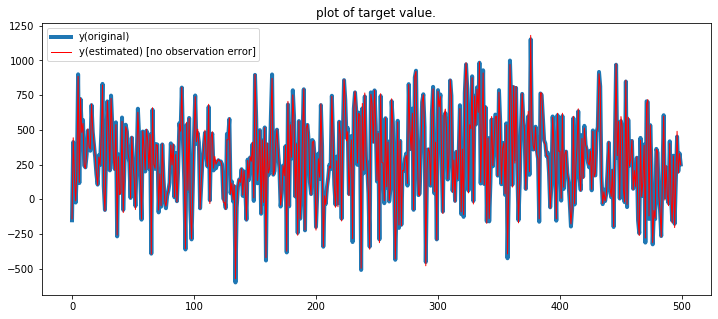

In [36]:
plt.figure(figsize=(12,5))
plt.plot(y_noerror, lw=4, label="y(original)")
plt.plot(estimatedLevel, "r", lw=1, label="y(estimated) [no observation error]")
plt.legend(loc="best")
plt.title("plot of target value.")